In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.manual_seed(42)

In [130]:
VOCAB_SIZE = 3  # hyperparameter depending on the task
HEADS = 8
EMBED_DIM = 512
HEAD_DIM = EMBED_DIM // HEADS
D_PROB = 0.1

In [131]:
input_emb = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBED_DIM)
output_emb = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBED_DIM)

In [132]:
input_emb

Embedding(3, 512)

In [133]:
test = torch.LongTensor([[0, 1, 2], [2, 1, 0]])

In [134]:
do = input_emb(test)

## Head

In [135]:
key = nn.Linear(in_features=EMBED_DIM, out_features=HEAD_DIM, bias=False)
query = nn.Linear(in_features=EMBED_DIM, out_features=HEAD_DIM, bias=False)
value= nn.Linear(in_features=EMBED_DIM, out_features=HEAD_DIM, bias=False)

# TODO: figure out register buffer
# TODO: prototype tril
register_buffer = ('mask', torch.tril(torch.ones(HEAD_DIM, HEAD_DIM), diagonal=1))

dropout = nn.Dropout(D_PROB)

# t for tokens, so I think this is words in this case
_, t, d_k = do.size() 
k = key(do)
q = query(do)
v = value(do)
qk = (q@k.transpose(-1, -2)) / d_k ** 0.5

mask = torch.tril(torch.ones(HEAD_DIM, HEAD_DIM))

# if mask:
qk = qk.masked_fill(mask[:t, :t] == 0, float('-inf'))

# 0 is among batches so ith, jth inputs in each batch add to 1, we don't want this
# 1 is through the columns, which is the word so maybe
# 2 is the word vector entirely
qk = F.softmax(qk, dim=-1)
attn = qk @ v

# dropout occurs at the end of the sublayer before adding residual connections and layernorming
attn
attn = dropout(attn)

In [136]:
from model import Head

In [137]:
head = Head(HEAD_DIM, EMBED_DIM, True)

## MultiHeadAttention

In [138]:
from model import MultiHeadAttention

In [139]:
mha = MultiHeadAttention(HEADS, HEAD_DIM, EMBED_DIM, mask=True)
multi = mha(do, do, do)

In [140]:
torch.all(multi == do).item(), multi.size() == do.size() # we want this

(False, True)

## FeedForward

In [141]:
from model import FeedForward

In [142]:
ff = FeedForward(EMBED_DIM)
ff(multi).size()

torch.Size([2, 3, 512])

In [143]:
multi.size()

torch.Size([2, 3, 512])

## Encoder Block

In [144]:
from model import EncoderBlock

In [145]:
eb = EncoderBlock(HEADS, EMBED_DIM)
enc = eb(do)

In [146]:
enc.size()

torch.Size([2, 3, 512])

## Decoder Block

In [147]:
from model import DecoderBlock

In [148]:
db = DecoderBlock(HEADS, EMBED_DIM)
db(do, enc).size()

torch.Size([2, 3, 512])

## Positional Encodings

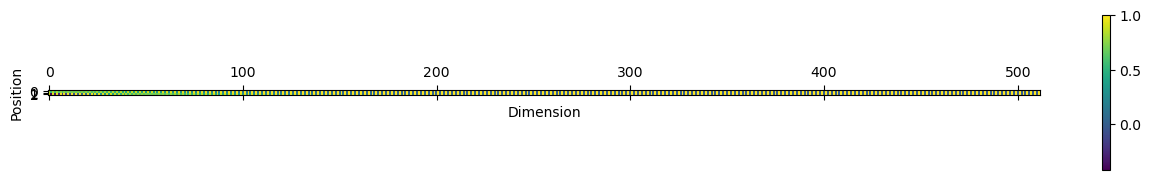

In [149]:
def pos_encoding(max_len, d_model):
    encoding = torch.zeros(max_len, d_model)
    pow = 2 * torch.arange(0, d_model//2) / d_model
    denom = 10_000 ** pow
    pos = torch.arange(0, max_len).view(-1, 1)
    encoding[:, ::2] = torch.sin(pos/denom)
    encoding[:, 1::2] = torch.cos(pos/denom)
    return encoding

def plot_positional_encoding(pos_enc):
    cax = plt.matshow(pos_enc.squeeze().numpy())
    plt.gcf().colorbar(cax)
    plt.xlabel('Dimension')
    plt.ylabel('Position')
    plt.show()

# Example usage
max_len = 3
d_model = 512  # Adjust the dimensionality as needed
pos_enc = pos_encoding(max_len, d_model)
plot_positional_encoding(pos_enc)

## Transformer

In [150]:
from model import Transformer

In [151]:
VOCAB_SIZE = 300  # hyperparameter depending on the task
HEADS = 8
EMBED_DIM = 512
HEAD_DIM = EMBED_DIM // HEADS
CONTEXT = 10
BATCH = 10
D_PROB = 0.1

In [152]:
optimus = Transformer(6, HEADS, EMBED_DIM, VOCAB_SIZE, CONTEXT)

In [153]:
pool = torch.randint(0, VOCAB_SIZE, (BATCH, CONTEXT+1))
x = pool[:, :CONTEXT]
trg = pool[:, 1:]
y = pool[:, 1:]
out = optimus(x, trg)

In [170]:
B, T, C = out.size()
B, T, C

(10, 10, 300)

In [155]:
out.view(B*T, C).size()

torch.Size([100, 300])

In [156]:
x.size(), y.size()

(torch.Size([10, 10]), torch.Size([10, 10]))

In [157]:
y.reshape(B*T)

tensor([258, 225,  11, 133, 151, 211, 115, 295,  77,  42, 265, 225,  38,   1,
         52, 218, 103, 283,  87,   5,  64, 189,  93,  65, 294, 173, 262,  13,
        279, 110, 214,  55, 168, 251, 203, 137, 273, 244,  25, 192, 197,  32,
          4, 108, 186, 136,  76, 247, 245, 261,  21, 111,  86, 113,  42,  13,
        139,  79, 262, 146, 153, 273, 227, 198,  95, 218, 279, 267,  67, 210,
        213, 283,  15, 129, 129, 215, 251, 275, 125,  34, 181, 285,  30, 259,
        268,  73, 237,  45, 268,  92, 162, 210,   8,  97, 175, 129,  77, 166,
        156, 116])

In [158]:
F.cross_entropy(out.view(B*T, C), y.reshape(B*T))

tensor(5.7311, grad_fn=<NllLossBackward0>)

## Dataset

In [159]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import spacy
import time

class Paraphrase(Dataset):
    def __init__(self, src_dir, trg_dir, nlp):
        """Initialization, we need a directory to load as well as tokenization framework"""
        start = time.time()
        self.nlp = nlp
        src = self.open(src_dir)
        trg = self.open(trg_dir)
        data_pairs = list(zip(src, trg))
        
        # by itself this will take ~90 seconds, there's no real way to get around this besides compute
        self.data = [(self.tokenize(doc), self.tokenize(summary)) for doc, summary in data_pairs]
        
        # just caching to make it much easier to access, save computation if needed
        self._map()
        self._max_context = max([len(src) for src, _ in self.data])
        end = time.time()
        print(f"Total time for dataset initialization was {end - start}")

    def __len__(self):
        """Length method that is needed for PyTorch DataLoader"""
        return len(self.data)

    def __getitem__(self, idx):
        """Get item method that is also needed to PyTorch's DataLoader"""
        src, trg = self.data[idx]
        src = torch.tensor([self.stoi[s] for s in src])
        trg = torch.tensor([self.stoi[t] for t in trg])
        return (src, trg)

    def _map(self):
        """Creates a string-to-index and index-to-string based on sorted vocab"""
        self._vocabulary()
        self.stoi = {v:i for v, i in zip(self.vocab, range(self.vocab_size()))}
        self.itos = {i:v for v, i in zip(self.vocab, range(self.vocab_size()))}
    
    def map(self, map="both"):
        """Getter method if we want to double check stoi and itos"""
        try:
            if map == "itos":
                return self.itos
            elif map == "stoi":
                return self.stoi
            elif map == "both":
                return (self.itos, self.stoi)
            else:
                raise
        except Exception as e:
            raise AttributeError(f"Takes stoi, itos, or both. You gave {map}")

    # need to find the max length so that we can pad accordingly
    def _vocabulary(self):
        """Finding the unique words in the train and test set together for itos and stoi"""
        train_set = set([token for train, _ in self.data for token in train])
        test_set = set([token for _, test in self.data for token in test])
        t = train_set | test_set
        t.add("<p>")
        self.vocab = sorted(t)

    def vocab(self):
        """Getter method to check the vocab if we need it"""
        return self.vocab

    def vocab_size(self):
        """Getter method for the vocab size"""
        return len(self.vocab)

    def max_context(self):
        """Getter method for returning the max context"""
        return self._max_context

    def tokenize(self, text):
        """Tokenization utilizing spaCy's tokenzation in list comprehension; tokens manually added since it's easier"""
        t = [token.text.lower() for token in self.nlp.tokenizer(text)]
        # it's easier if we manually add the tokens after spaCy's tokenization so we have more granularity
        return ["<s>"] + t + ["<e>"]

    def open(self, path):
        """Opening the files using utf-8"""
        with open(path, 'r', encoding='utf-8') as file:
            file = file.readlines()
            file = [line.strip()for line in file]
        return file

In [160]:
spacy_en = spacy.load('en_core_web_sm')
src_file_path = "../../data/paraphrases/train/train.src"
tgt_file_path = "../../data/paraphrases/train/train.tgt"

p = Paraphrase(src_file_path, tgt_file_path, spacy_en)

Total time for dataset initialization was 95.70477771759033


tokenize -> turn entire trg and src into set -> get vocab size

In [161]:
itos, stoi = p.map("both")

In [162]:
stoi["<p>"]

2683

In [163]:
itos[2684]

'<s>'

In [164]:
p[2]

(tensor([ 2684,  7270, 45806, 64819, 68660, 21093,  9047, 66291,     2, 64819,
         60294, 46077, 10724,  7527, 48284, 70843,  2685, 13726, 45806, 64819,
         46291, 45469, 45089,     2,   820,  2682]),
 tensor([ 2684, 41595,     2,  6106, 24552, 35879, 33897,     2, 64819, 60294,
         46077, 10724,  7527, 48284, 70843,  2685, 13726, 45806, 64819, 46291,
         45469, 45089,     2,  3044, 65489, 64819, 68660, 21093,  9047, 66291,
           820,  2682]))

In [165]:
def custom_collate_fn(batch):
    train = [t for t, _ in batch]
    test = [t for _, t in batch]
    
    pad_src = pad_sequence(train, batch_first=True, padding_value=2683)
    pad_trg = pad_sequence(test, batch_first=True, padding_value=2683)

    return pad_src, pad_trg

In [166]:
d = DataLoader(p, batch_size=64, collate_fn=custom_collate_fn)

In [167]:
VOCAB_SIZE = p.vocab_size()
CONTEXT = p.max_context()
optimus = Transformer(6, HEADS, EMBED_DIM, VOCAB_SIZE, CONTEXT)

In [168]:
in_emb = optimus.in_emb
out_emb = optimus.out_emb
pos = optimus.pos_enc

In [184]:
for i, t in d:
    B, T = t.size()
    try:
        # _, Ta = i.size()
        # _, Tb = t.size()
        # a = in_emb(i) + pos[:Ta]
        # b = out_emb(t) + pos[:Tb]
        for i in range(1, T):
            print(t[:, :i].size())
    except Exception as e:
        print(e)

    break

torch.Size([64, 1])
torch.Size([64, 2])
torch.Size([64, 3])
torch.Size([64, 4])
torch.Size([64, 5])
torch.Size([64, 6])
torch.Size([64, 7])
torch.Size([64, 8])
torch.Size([64, 9])
torch.Size([64, 10])
torch.Size([64, 11])
torch.Size([64, 12])
torch.Size([64, 13])
torch.Size([64, 14])
torch.Size([64, 15])
torch.Size([64, 16])
torch.Size([64, 17])
torch.Size([64, 18])
torch.Size([64, 19])
torch.Size([64, 20])
torch.Size([64, 21])
torch.Size([64, 22])
torch.Size([64, 23])
torch.Size([64, 24])
torch.Size([64, 25])
torch.Size([64, 26])
torch.Size([64, 27])
torch.Size([64, 28])
torch.Size([64, 29])
torch.Size([64, 30])
torch.Size([64, 31])
torch.Size([64, 32])
torch.Size([64, 33])
torch.Size([64, 34])
torch.Size([64, 35])
torch.Size([64, 36])
torch.Size([64, 37])
torch.Size([64, 38])
torch.Size([64, 39])


[1]